# Midterm

In [1]:
import secrets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

sns.set_context("paper")

In [2]:
data_path = Path().resolve().parent / "data"

In [3]:
# Random seed for reproducibility
# secrets.randbits(128) # 208905213533139122735706682150229709525
rng = np.random.default_rng(208905213533139122735706682150229709525)
indices_train = rng.choice(5000, 2500, replace=False)
indices_test = rng.choice(800, 400, replace=False)
flag_full_dataset = False  # If it is True it will use full train and test datasets

In [4]:
train_list = []  # Auxiliary list of train datasets
for f in data_path.glob("train*.txt"):
    # Sample or full dataset
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_train, :]
    target = raw_data[:, [0]]  # Target values, i.e. digit
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    train_list.append(np.hstack((target, features)))  # Add to the temp list
train_data = np.vstack(train_list)  # Concatenate train datasets
train_data.shape

(25000, 785)

In [5]:
# Similar to train dataset
test_list = []
for f in data_path.glob("test*.txt"):
    raw_data = np.loadtxt(f) if flag_full_dataset else np.loadtxt(f)[indices_test, :]
    target = raw_data[:, [0]]
    features = raw_data[:, 1:] / raw_data[:, 1:].max(axis=1, keepdims=True)
    test_list.append(np.hstack((target, features)))
test_data = np.vstack(test_list)
test_data.shape

(4000, 785)

In [6]:
# Split datasets into features matrices and target vectors
X_train_tmp = train_data[:, 1:]
y_train_tmp = train_data[:, 0].astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_tmp,
    y_train_tmp,
    test_size=0.2,
    random_state=42
)
y_train_encoded = pd.get_dummies(y_train).to_numpy()
y_val_encoded = pd.get_dummies(y_val).to_numpy()
X_test = test_data[:, 1:]
y_test = test_data[:, 0].astype(int)

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(x, W_hidden, bias_hidden, W_output, bias_output):
    hidden = sigmoid(W_hidden @ x + bias_hidden)
    output = sigmoid(W_output @ hidden + bias_output)
    return hidden, output


def backward(x, target, W_hidden, bias_hidden, W_output, bias_output, hidden, output, eta):
    # Errors
    delta_output = output * (1 - output) * (target - output)
    delta_hidden = hidden * (1 - hidden) * W_output.T @ delta_output
    # Update
    D_W_hidden = eta * delta_hidden @ x.T
    D_bias_hidden = eta * delta_hidden
    D_W_output = eta * delta_output @ hidden.T
    D_bias_output = eta * delta_output
    W_hidden = W_hidden + D_W_hidden
    bias_hidden = bias_hidden + D_bias_hidden
    W_output = W_output + D_W_output
    bias_output = bias_output + D_bias_output
    return W_hidden, bias_hidden, W_output, bias_output


def predict(X, W_hidden, bias_hidden, W_output, bias_output):
    y_pred = np.empty(shape=X.shape[0])
    for k in range(X.shape[0]):
        _, pred = forward(X[k:k + 1, :].T, W_hidden, bias_hidden, W_output, bias_output)
        y_pred[k] = pred.argmax()  # Argmax
    return y_pred


def accuracy(y_pred, y_real):
    return np.mean(y_pred == y_real)


def trainning(X_train, y_train, X_val, y_val, n_hidden, epochs, eta, init_min, init_max, tol):
    n_samples, n_feature = X_train.shape  # Samples and features
    n_output = np.unique(y_train).size  # Unique number of digits/classes
    # Initialization
    W_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, n_feature))
    bias_hidden = np.random.uniform(init_min, init_max, size=(n_hidden, 1))
    W_output = np.random.uniform(init_min, init_max, size=(n_output, n_hidden))
    bias_output = np.random.uniform(init_min, init_max, size=(n_output, 1))
    # Iteration
    train_errors = []
    val_errors = []
    for j in range(epochs):
        # Shuffle training samples
        idx_permutation = rng.permutation(n_samples)
        X_train = X_train[idx_permutation, :]
        y_train = y_train[idx_permutation]
        # One hot encoded
        y_train_encoded = pd.get_dummies(y_train).to_numpy()
        for i in range(n_samples):
            x = X_train[i:i + 1, :].T  # x Vector
            target = y_train_encoded[i:i + 1, :].T  # Encoded target vector
            hidden, output = forward(x, W_hidden, bias_hidden, W_output, bias_output)
            W_hidden, bias_hidden, W_output, bias_output = backward(
                x,
                target,
                W_hidden,
                bias_hidden,
                W_output,
                bias_output,
                hidden,
                output,
                eta
            )
        # Store errors
        y_pred_train = predict(X_train, W_hidden, bias_hidden, W_output, bias_output)
        y_pred_val = predict(X_val, W_hidden, bias_hidden, W_output, bias_output)
        train_error = 1 - accuracy(y_pred_train, y_train)
        val_error = 1 - accuracy(y_pred_val, y_val)
        train_errors.append(train_error)
        val_errors.append(val_error)
        # Print train and validation errors each 10 epochs
        if (j + 1) % 10 == 0:
            print(
                f"--- Epoch {j + 1}" + \
                f" - Train error: {train_error:.3f} "+ \
                f" - Validation error: {val_error:.3f}"
            )
            # Tolerance check
            if np.abs((val_errors[-1] - val_errors[-2]) / val_errors[-2]) < tol:
                print("Validation error tolerance has been reached")
                break
    val_errors = np.array(val_errors)
    train_errors = np.array(train_errors)
    return W_hidden, bias_hidden, W_output, bias_output, train_errors, val_errors

In [8]:
epochs = 100
eta = 0.05
init_min = -0.05
init_max = 0.05
tol = 1e-16

In [9]:
train_errors_dict = {}
val_errors_dict = {}
test_error_dict = {}
pred_dict = {}
parameters_dict = {}
n_hiddens = [2, 3, 4, 6, 8, 10]  # Different numbers of hidden units
for n_hidden in n_hiddens:
    print(f"ANN with {n_hidden} hidden units")
    W_hidden, bias_hidden, W_output, bias_output, train_errors, val_errors = trainning(
        X_train,
        y_train,
        X_val,
        y_val,
        n_hidden,
        epochs,
        eta,
        init_min,
        init_max,
        tol
    )
    y_pred = predict(X_test, W_hidden, bias_hidden, W_output, bias_output)
    test_error = accuracy(y_pred, y_test)
    train_errors_dict[n_hidden] = train_errors
    val_errors_dict[n_hidden] = val_errors
    test_error_dict[n_hidden] = test_error
    pred_dict[n_hidden] = y_pred
    parameters_dict[n_hidden] = [W_hidden, bias_hidden, W_output, bias_output]

ANN with 2 hidden units
--- Epoch 10 - Train error: 0.625  - Validation error: 0.624
--- Epoch 20 - Train error: 0.635  - Validation error: 0.633
--- Epoch 30 - Train error: 0.595  - Validation error: 0.594
--- Epoch 40 - Train error: 0.579  - Validation error: 0.581
--- Epoch 50 - Train error: 0.561  - Validation error: 0.568
--- Epoch 60 - Train error: 0.564  - Validation error: 0.571
--- Epoch 70 - Train error: 0.569  - Validation error: 0.580
--- Epoch 80 - Train error: 0.566  - Validation error: 0.567
--- Epoch 90 - Train error: 0.577  - Validation error: 0.576
--- Epoch 100 - Train error: 0.602  - Validation error: 0.604
ANN with 3 hidden units
--- Epoch 10 - Train error: 0.525  - Validation error: 0.532
--- Epoch 20 - Train error: 0.456  - Validation error: 0.463
--- Epoch 30 - Train error: 0.442  - Validation error: 0.457
--- Epoch 40 - Train error: 0.410  - Validation error: 0.425
--- Epoch 50 - Train error: 0.426  - Validation error: 0.450
--- Epoch 60 - Train error: 0.402  -

/tmp/ipykernel_25005/1996587593.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


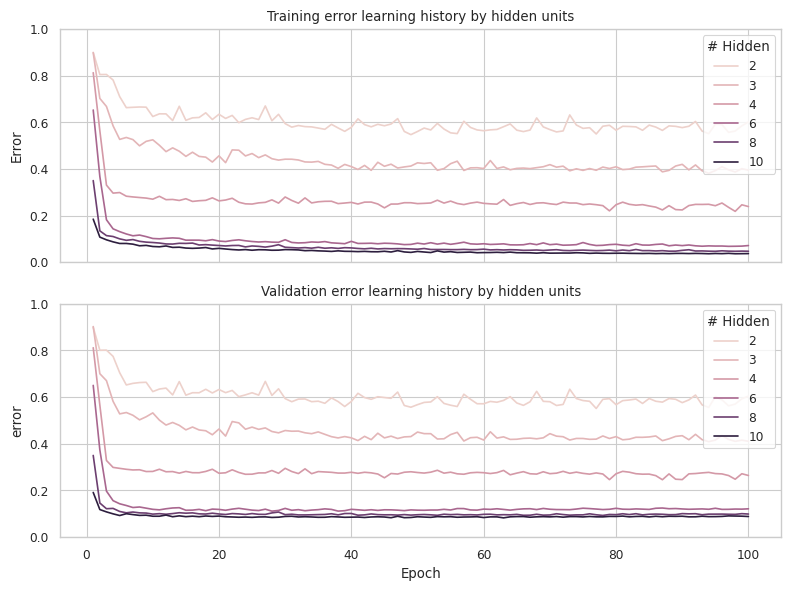

In [11]:
# Plot learning history
train_error_df = (
    pd.DataFrame(train_errors_dict)
    .assign(epoch=lambda x: x.index + 1)
    .melt(id_vars="epoch", var_name="n_hidden", value_name="error")
)
val_error_df = (
    pd.DataFrame(val_errors_dict)
    .assign(epoch=lambda x: x.index + 1)
    .melt(id_vars="epoch", var_name="n_hidden", value_name="error")
)
train_error_df.to_csv(f"train_error_{flag_full_dataset}.csv")
val_error_df.to_csv(f"validation_error_{flag_full_dataset}.csv")
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True, sharey=True)
    sns.lineplot(
        data=train_error_df,
        x="epoch",
        y="error",
        hue="n_hidden",
        ax=ax1
    )
    sns.lineplot(
        data=val_error_df,
        x="epoch",
        y="error",
        hue="n_hidden",
        ax=ax2
    )
    ax1.set_title(f"Training error learning history by hidden units")
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("Error")
    ax1.legend(title="# Hidden")
    ax2.set_title(f"Validation error learning history by hidden units")
    ax2.set_xlabel("Epoch")
    ax2.legend(title="# Hidden")
    fig.tight_layout()
    fig.savefig(f"ann_learning_history_{flag_full_dataset}.png", dpi=300)
    fig.show()

/tmp/ipykernel_25005/893436133.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


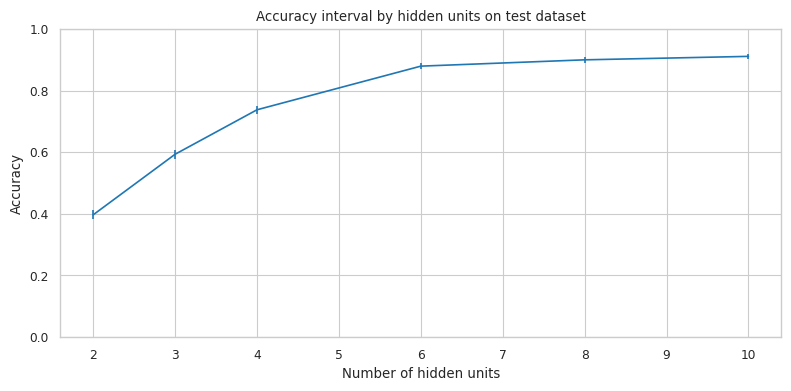

In [12]:
# Plot confidence interval for test dataset
test_accuracy = np.array(list(test_error_dict.values()))
test_sigma = np.sqrt(test_accuracy * (1 - test_accuracy) / y_test.size)
test_error_lower =  1.96 * test_sigma
test_error_upper =  1.96 * test_sigma
asymmetric_error = [test_error_lower, test_error_upper]
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.errorbar(
        n_hiddens,
        test_accuracy,
        yerr=asymmetric_error
    )
    ax.set_ylim(0, 1)
    ax.set_xlabel("Number of hidden units")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"Accuracy interval by hidden units on test dataset")
    fig.tight_layout()
    fig.savefig(f"ann_accuracy_interval_{flag_full_dataset}.png", dpi=300)
    fig.show()

Accuracy with 2 hidden layers was 39.67% and with approximately 95% probability the true accuracy lies in the interval [0.3816, 0.4119]
Accuracy with 3 hidden layers was 59.35% and with approximately 95% probability the true accuracy lies in the interval [0.5783, 0.6087]


/tmp/ipykernel_25005/1298091397.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();
/tmp/ipykernel_25005/1298091397.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


Accuracy with 4 hidden layers was 73.80% and with approximately 95% probability the true accuracy lies in the interval [0.7244, 0.7516]
Accuracy with 10 hidden layers was 91.15% and with approximately 95% probability the true accuracy lies in the interval [0.9027, 0.9203]


/tmp/ipykernel_25005/1298091397.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();
/tmp/ipykernel_25005/1298091397.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


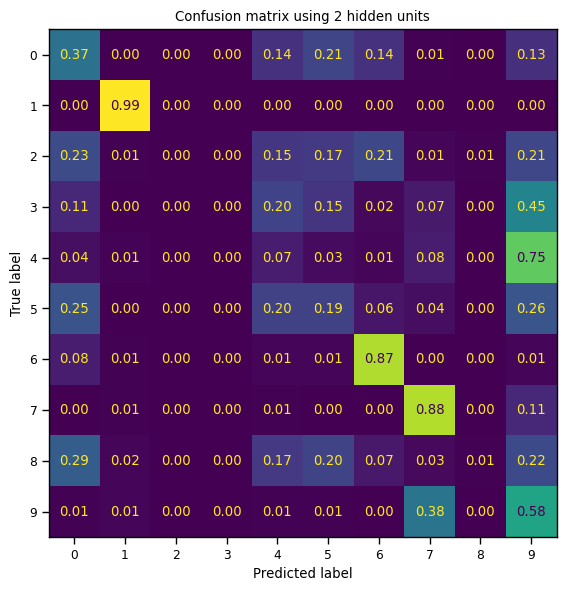

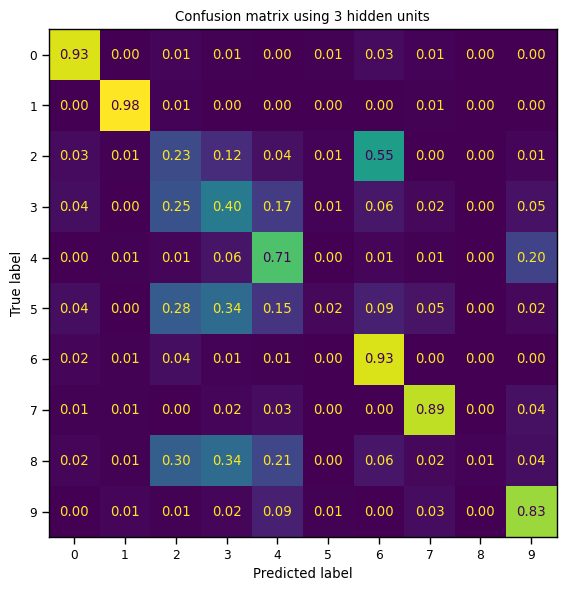

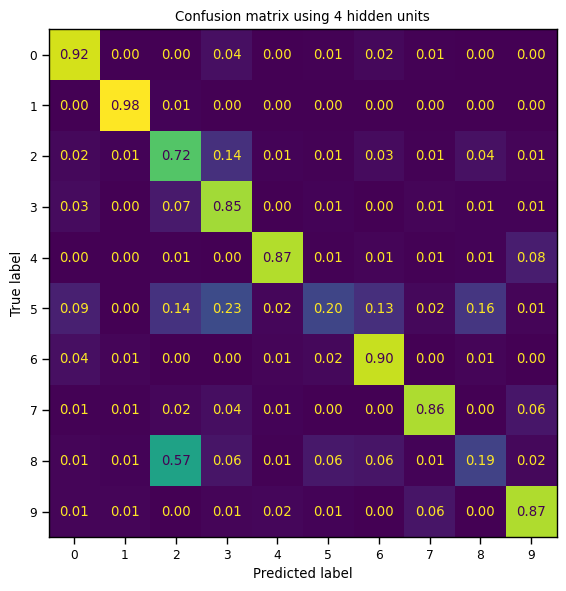

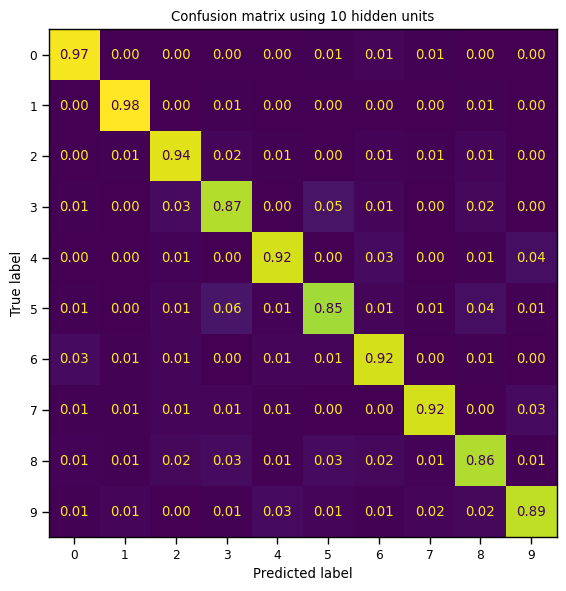

In [13]:
for n_hidden in [2, 3, 4, n_hiddens[-1]]:
    y_pred = pred_dict[n_hidden]
    error_h = accuracy(y_pred, y_test)
    sigma = np.sqrt(error_h * (1 - error_h) / y_test.size)
    print(
        f"Accuracy with {n_hidden} hidden layers was {error_h:.2%} and with " + \
        f"approximately 95% probability the true accuracy lies in the interval " + \
        f"[{error_h - 1.96 * sigma:.4f}, {error_h + 1.96 * sigma:.4f}]"
    )
    # Confusion matrix - row normalization
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        normalize="true",
        values_format=".2f",
        ax=ax
    )
    ax.images[0].colorbar.remove()
    ax.set_title(f"Confusion matrix using {n_hidden} hidden units")
    fig.tight_layout()
    fig.savefig(
        f"ann_confusion_matrix_fulldata_{flag_full_dataset}_{n_hidden}.png",
        dpi=300
    )
    fig.show();